# Metric results comp notebook
This notebook just calcs and compares metrics of different models preds on the test set

In [1]:
import torch
import os
import sys
import torchmetrics
import torch
import pandas as pd
import sumolib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

In [3]:
sys.path.append('..')
from utils.ml_utils.data_utils.data_loader_utils import IncidentDataModule
from utils.ml_utils.result_utils.plot_utils import plotNet
from utils.dotdict import DotDict
from utils.ml_utils.result_utils.metric_utils import generate_masks, MetricObj
from utils.ml_utils.result_utils.plot_utils import plot_classification_errors, plot_net_w_logits

In [3]:
def print_res_dict(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            metric_str +=  f'{metric} : {res_dict[loss_part][metric]:.02f} \t'
        print(metric_str)

In [4]:
# Load results
base_dir = '../temp_results/wandb_temp'
model_names = os.listdir(base_dir)
model_names

y_hat_dict = {}
y_true_dict = {}
for name in model_names:
    y_hat_dict[name] = torch.load(f'{base_dir}/{name}/y_hat.pt').cpu()
    y_true_dict[name] = torch.load(f'{base_dir}/{name}/y_true.pt').cpu()

assert (y_true_dict['lstm'] - y_true_dict['informed_lstm']).sum() == 0
assert (y_true_dict['informed_lstm'] - y_true_dict['network_informed_lstm']).sum() == 0
assert (y_true_dict['network_informed_lstm'] - y_true_dict['gnn']).sum() == 0
assert (y_true_dict['gnn'] - y_true_dict['informed_gnn']).sum() == 0
assert (y_true_dict['informed_gnn'] - y_true_dict['lstm']).sum() == 0

# Load net and dataset info
folder_path = f'../motorway/Results/incident3'
incident_data_module = IncidentDataModule(folder_path = folder_path, batch_size = 100)
incident_data_module.setup()
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../motorway/Results/incident3/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

# Generate masks for subbsets
upstream_mask, multi_lane_block_mask, highway_ie_mask, spreading_cong_mask = generate_masks(test_dataset)

In [5]:
metric_obj = MetricObj(bce_pos_weight=22.5178)
full_test = {}
full_test['lstm'] = metric_obj.calc_metrics(y_hat=y_hat_dict['lstm'],
                                            y_true=y_true_dict['lstm'])

full_test['informed_lstm'] = metric_obj.calc_metrics(y_hat=y_hat_dict['informed_lstm'], 
                                                     y_true=y_true_dict['informed_lstm'])

full_test['network_informed_lstm'] = metric_obj.calc_metrics(y_hat=y_hat_dict['network_informed_lstm'],
                                                             y_true=y_true_dict['network_informed_lstm'])


full_test['gnn'] = metric_obj.calc_metrics(y_hat=y_hat_dict['gnn'],
                                           y_true=y_true_dict['gnn'])

full_test['informed_gnn'] = metric_obj.calc_metrics(y_hat=y_hat_dict['informed_gnn'],
                                                             y_true=y_true_dict['informed_gnn'])

In [6]:
for model in full_test.keys():
    print_res_dict(full_test[model], model)

************  Results for: lstm  ************
##class:##
bce : 1.20 	acc : 0.82 	prcsn : 0.12 	rcll : 0.46 	
##start:##
mse : 58.07 	mae : 1.66 	mape : 569899.06 	Mmape : 0.88 	
##end:##
mse : 382.79 	mae : 5.40 	mape : 1882254.50 	Mmape : 0.91 	
##speed:##
mse : 21.36 	mae : 1.46 	mape : 484559.25 	Mmape : 0.92 	
************  Results for: informed_lstm  ************
##class:##
bce : 1.35 	acc : 0.96 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 58.82 	mae : 1.65 	mape : 540724.31 	Mmape : 0.91 	
##end:##
mse : 396.45 	mae : 5.26 	mape : 1657583.88 	Mmape : 0.94 	
##speed:##
mse : 22.88 	mae : 1.55 	mape : 519786.91 	Mmape : 0.97 	
************  Results for: network_informed_lstm  ************
##class:##
bce : 0.63 	acc : 0.77 	prcsn : 0.16 	rcll : 1.00 	
##start:##
mse : 57.06 	mae : 1.82 	mape : 758715.19 	Mmape : 0.79 	
##end:##
mse : 373.80 	mae : 5.81 	mape : 2400976.25 	Mmape : 0.80 	
##speed:##
mse : 20.06 	mae : 1.67 	mape : 722247.62 	Mmape : 0.83 	
************  Results for:

# LSTM Focus

In [7]:
metric_obj = MetricObj(bce_pos_weight=22.5178)
model_str = 'lstm'
model_res_dict = {}
model_res_dict['full'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                            y_true=y_true_dict[model_str])

model_res_dict['upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=upstream_mask)

model_res_dict['not_upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~upstream_mask)

model_res_dict['multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=multi_lane_block_mask)

model_res_dict['not_multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~multi_lane_block_mask)

model_res_dict['highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=highway_ie_mask)

model_res_dict['not_highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~highway_ie_mask)
                                                
model_res_dict['spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=spreading_cong_mask)

model_res_dict['not_spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~spreading_cong_mask)

In [8]:
for mask_type in model_res_dict.keys():
    print_res_dict(model_res_dict[mask_type], mask_type)

************  Results for: full  ************
##class:##
bce : 1.20 	acc : 0.82 	prcsn : 0.12 	rcll : 0.46 	
##start:##
mse : 58.07 	mae : 1.66 	mape : 569899.06 	Mmape : 0.88 	
##end:##
mse : 382.79 	mae : 5.40 	mape : 1882254.50 	Mmape : 0.91 	
##speed:##
mse : 21.36 	mae : 1.46 	mape : 484559.25 	Mmape : 0.92 	
************  Results for: upstream  ************
##class:##
bce : 4.49 	acc : 0.66 	prcsn : 0.42 	rcll : 0.46 	
##start:##
mse : 362.57 	mae : 7.23 	mape : 712146.94 	Mmape : 0.88 	
##end:##
mse : 2343.66 	mae : 23.39 	mape : 2287759.25 	Mmape : 0.91 	
##speed:##
mse : 130.18 	mae : 6.46 	mape : 568405.00 	Mmape : 0.92 	
************  Results for: not_upstream  ************
##class:##
bce : 0.60 	acc : 0.85 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 2.41 	mae : 0.64 	mape : 543896.62 	Mmape : nan 	
##end:##
mse : 24.35 	mae : 2.12 	mape : 1808129.50 	Mmape : nan 	
##speed:##
mse : 1.47 	mae : 0.55 	mape : 469232.44 	Mmape : nan 	
************  Results for: multi_lane  ***

Text(0.5, 1.0, 'lstm')

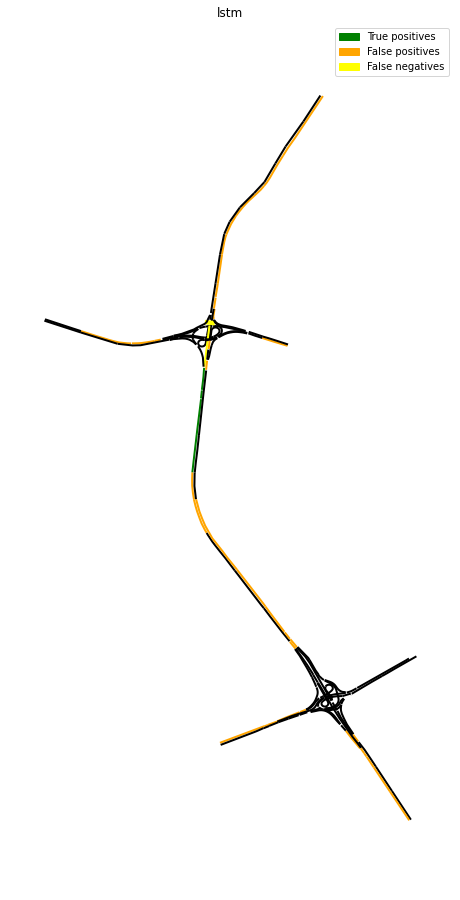

In [9]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=y_hat_dict[model_str],
y_true=y_true_dict[model_str],
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'lstm')

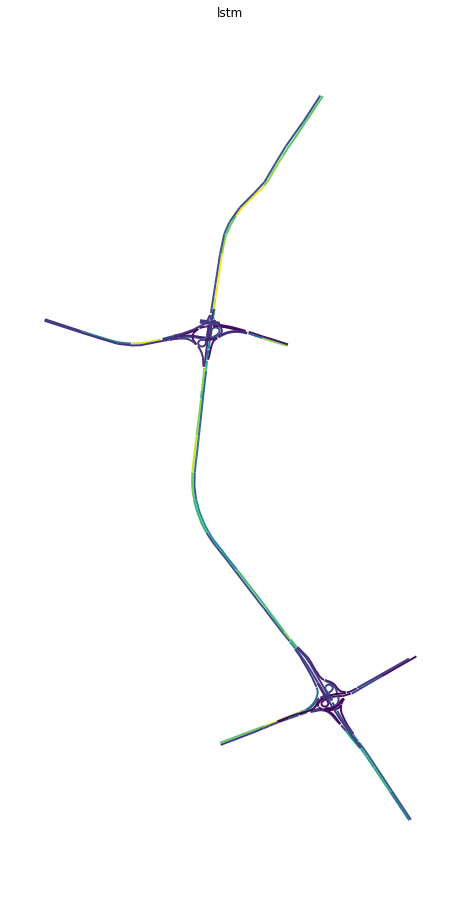

In [10]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=y_hat_dict[model_str],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'False neg')

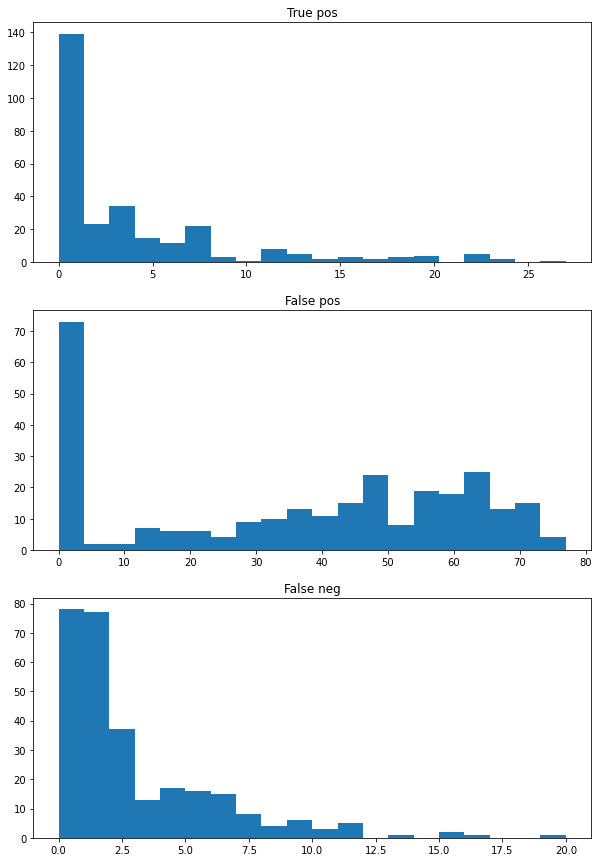

In [11]:
pred_classes = y_hat_dict[model_str][...,0] > 0
true_classes = y_true_dict[model_str][...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# Informed LSTM Focus

In [12]:
metric_obj = MetricObj(bce_pos_weight=22.5178)
model_str = 'informed_lstm'
model_res_dict = {}
model_res_dict['full'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                            y_true=y_true_dict[model_str])

model_res_dict['upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=upstream_mask)

model_res_dict['not_upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~upstream_mask)

model_res_dict['multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=multi_lane_block_mask)

model_res_dict['not_multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~multi_lane_block_mask)

model_res_dict['highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=highway_ie_mask)

model_res_dict['not_highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~highway_ie_mask)
                                                
model_res_dict['spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=spreading_cong_mask)

model_res_dict['not_spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~spreading_cong_mask)

In [13]:
for mask_type in model_res_dict.keys():
    print_res_dict(model_res_dict[mask_type], mask_type)

************  Results for: full  ************
##class:##
bce : 1.35 	acc : 0.96 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 58.82 	mae : 1.65 	mape : 540724.31 	Mmape : 0.91 	
##end:##
mse : 396.45 	mae : 5.26 	mape : 1657583.88 	Mmape : 0.94 	
##speed:##
mse : 22.88 	mae : 1.55 	mape : 519786.91 	Mmape : 0.97 	
************  Results for: upstream  ************
##class:##
bce : 4.85 	acc : 0.71 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 371.04 	mae : 7.08 	mape : 440879.19 	Mmape : 0.91 	
##end:##
mse : 2501.85 	mae : 23.01 	mape : 1307150.75 	Mmape : 0.94 	
##speed:##
mse : 143.50 	mae : 6.56 	mape : 373064.78 	Mmape : 0.97 	
************  Results for: not_upstream  ************
##class:##
bce : 0.71 	acc : 1.00 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 1.74 	mae : 0.65 	mape : 558975.69 	Mmape : nan 	
##end:##
mse : 11.59 	mae : 2.01 	mape : 1721642.00 	Mmape : nan 	
##speed:##
mse : 0.83 	mae : 0.64 	mape : 546607.25 	Mmape : nan 	
************  Results for: multi_lane  ***

Text(0.5, 1.0, 'informed_lstm')

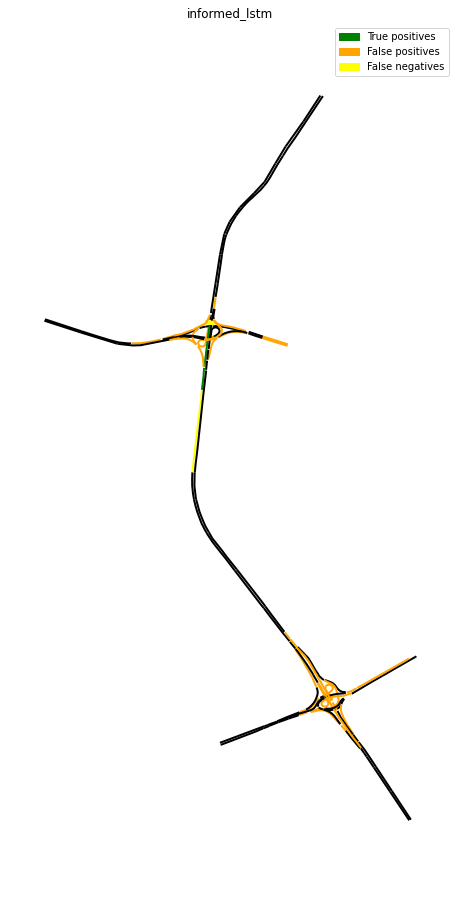

In [14]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=y_hat_dict[model_str],
                            y_true=y_true_dict[model_str],
                            seq_num=6,
                            incident_info=test_dataset.incident_info,
                            ind_to_edge=ind_to_edge,
                            net=net,
                            ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'informed_lstm')

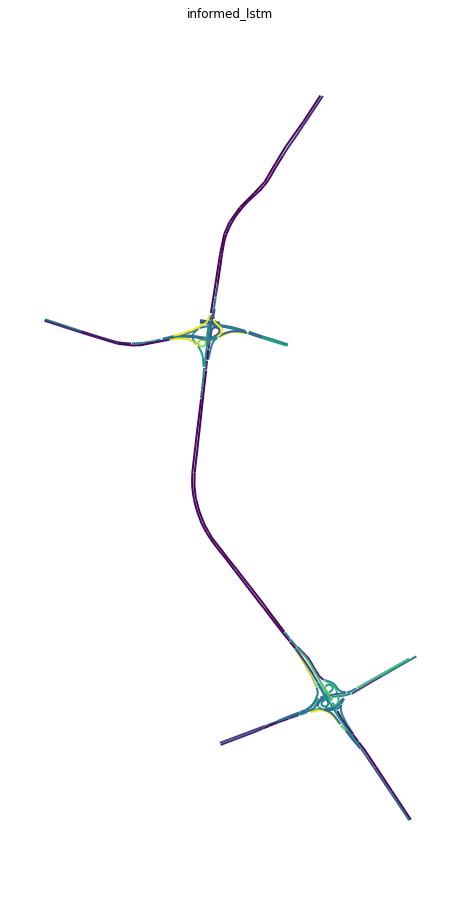

In [15]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=y_hat_dict[model_str],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'False neg')

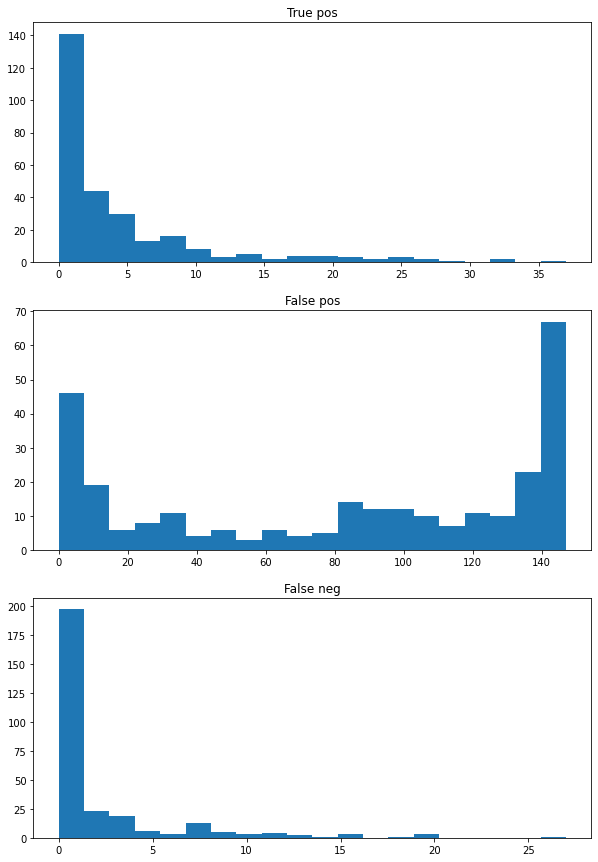

In [16]:
pred_classes = y_hat_dict[model_str][...,0] > 0
true_classes = y_true_dict[model_str][...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# Network Informed LSTM Focus

In [17]:
metric_obj = MetricObj(bce_pos_weight=22.5178)
model_str = 'network_informed_lstm'
model_res_dict = {}
model_res_dict['full'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                            y_true=y_true_dict[model_str])

model_res_dict['upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=upstream_mask)

model_res_dict['not_upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~upstream_mask)

model_res_dict['multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=multi_lane_block_mask)

model_res_dict['not_multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~multi_lane_block_mask)

model_res_dict['highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=highway_ie_mask)

model_res_dict['not_highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~highway_ie_mask)
                                                
model_res_dict['spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=spreading_cong_mask)

model_res_dict['not_spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~spreading_cong_mask)

In [18]:
for mask_type in model_res_dict.keys():
    print_res_dict(model_res_dict[mask_type], mask_type)

************  Results for: full  ************
##class:##
bce : 0.63 	acc : 0.77 	prcsn : 0.16 	rcll : 1.00 	
##start:##
mse : 57.06 	mae : 1.82 	mape : 758715.19 	Mmape : 0.79 	
##end:##
mse : 373.80 	mae : 5.81 	mape : 2400976.25 	Mmape : 0.80 	
##speed:##
mse : 20.06 	mae : 1.67 	mape : 722247.62 	Mmape : 0.83 	
************  Results for: upstream  ************
##class:##
bce : 2.88 	acc : 0.29 	prcsn : 0.29 	rcll : 1.00 	
##start:##
mse : 356.31 	mae : 8.29 	mape : 1929467.38 	Mmape : 0.79 	
##end:##
mse : 2303.39 	mae : 27.15 	mape : 6620412.50 	Mmape : 0.80 	
##speed:##
mse : 118.23 	mae : 7.52 	mape : 1857488.75 	Mmape : 0.83 	
************  Results for: not_upstream  ************
##class:##
bce : 0.22 	acc : 0.86 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 2.36 	mae : 0.64 	mape : 544705.19 	Mmape : nan 	
##end:##
mse : 21.07 	mae : 1.91 	mape : 1629676.25 	Mmape : nan 	
##speed:##
mse : 2.11 	mae : 0.60 	mape : 514728.97 	Mmape : nan 	
************  Results for: multi_lane  *

Text(0.5, 1.0, 'network_informed_lstm')

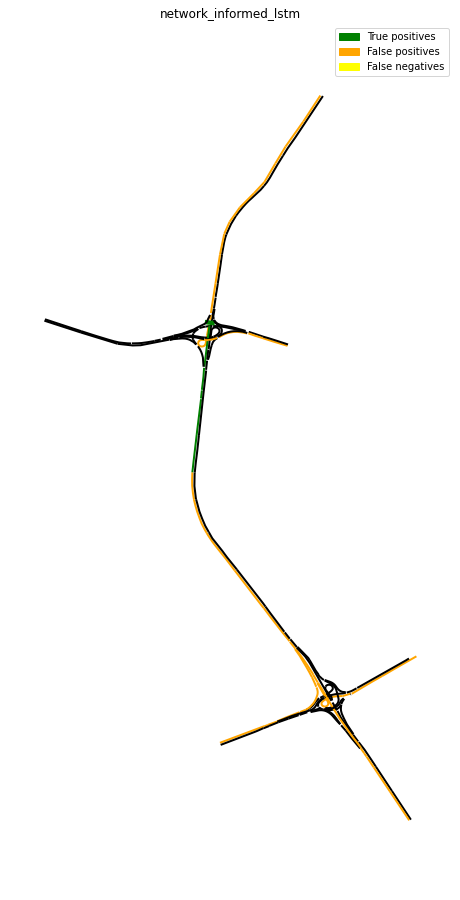

In [19]:
fig, ax = plt.subplots(figsize=(8,16))
fig1 = plot_classification_errors(y_hat=y_hat_dict[model_str],
y_true=y_true_dict[model_str],
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'network_informed_lstm')

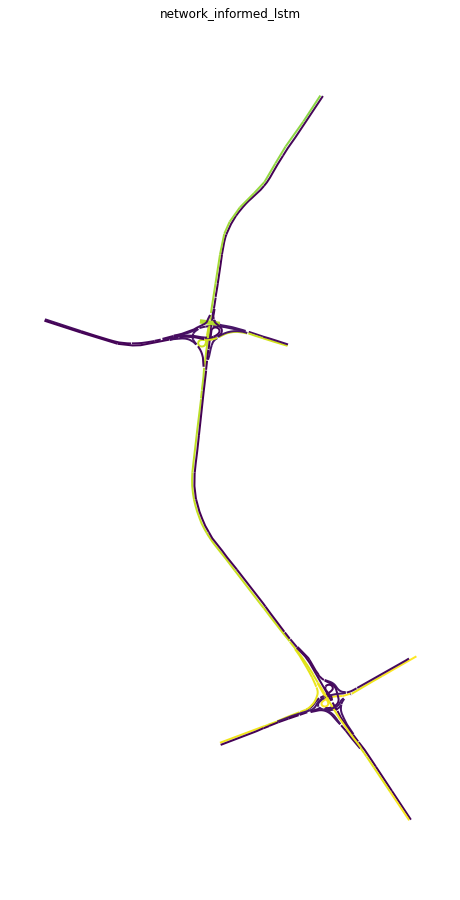

In [20]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=y_hat_dict[model_str],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'False neg')

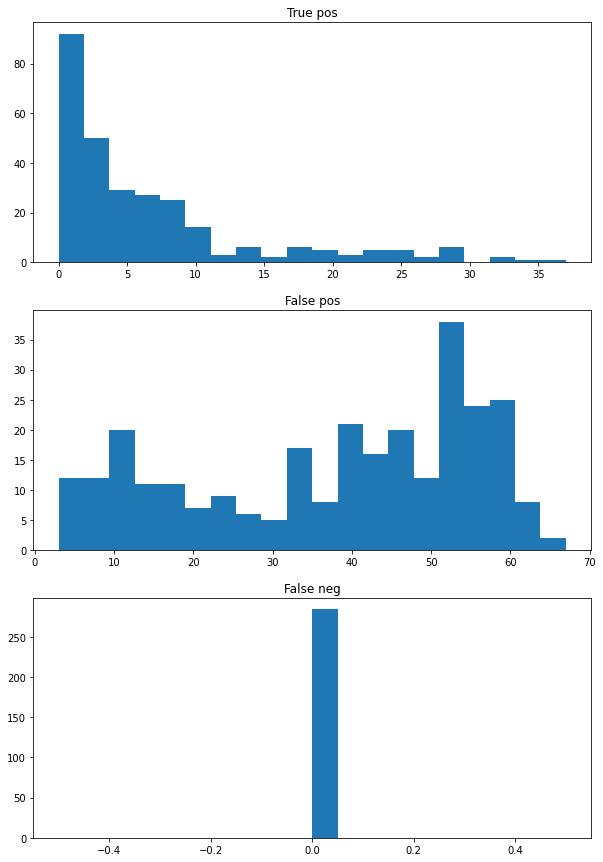

In [21]:
pred_classes = y_hat_dict[model_str][...,0] > 0
true_classes = y_true_dict[model_str][...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# GNN Focus

In [22]:
metric_obj = MetricObj(bce_pos_weight=22.5178)
model_str = 'gnn'
model_res_dict = {}
model_res_dict['full'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                            y_true=y_true_dict[model_str])

model_res_dict['upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=upstream_mask)

model_res_dict['not_upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~upstream_mask)

model_res_dict['multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=multi_lane_block_mask)

model_res_dict['not_multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~multi_lane_block_mask)

model_res_dict['highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=highway_ie_mask)

model_res_dict['not_highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~highway_ie_mask)
                                                
model_res_dict['spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=spreading_cong_mask)

model_res_dict['not_spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~spreading_cong_mask)

In [23]:
for mask_type in model_res_dict.keys():
    print_res_dict(model_res_dict[mask_type], mask_type)

************  Results for: full  ************
##class:##
bce : 1.27 	acc : 0.82 	prcsn : 0.09 	rcll : 0.35 	
##start:##
mse : 59.11 	mae : 1.66 	mape : 543649.00 	Mmape : 0.92 	
##end:##
mse : 394.96 	mae : 5.49 	mape : 1880320.25 	Mmape : 0.93 	
##speed:##
mse : 21.73 	mae : 1.47 	mape : 474257.09 	Mmape : 0.95 	
************  Results for: upstream  ************
##class:##
bce : 4.67 	acc : 0.64 	prcsn : 0.37 	rcll : 0.35 	
##start:##
mse : 374.40 	mae : 7.24 	mape : 543626.69 	Mmape : 0.92 	
##end:##
mse : 2456.84 	mae : 23.48 	mape : 1892592.88 	Mmape : 0.93 	
##speed:##
mse : 134.95 	mae : 6.46 	mape : 452584.44 	Mmape : 0.95 	
************  Results for: not_upstream  ************
##class:##
bce : 0.65 	acc : 0.85 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 1.48 	mae : 0.64 	mape : 543653.12 	Mmape : nan 	
##end:##
mse : 18.06 	mae : 2.20 	mape : 1878076.88 	Mmape : nan 	
##speed:##
mse : 1.04 	mae : 0.56 	mape : 478218.75 	Mmape : nan 	
************  Results for: multi_lane  ***

Text(0.5, 1.0, 'gnn')

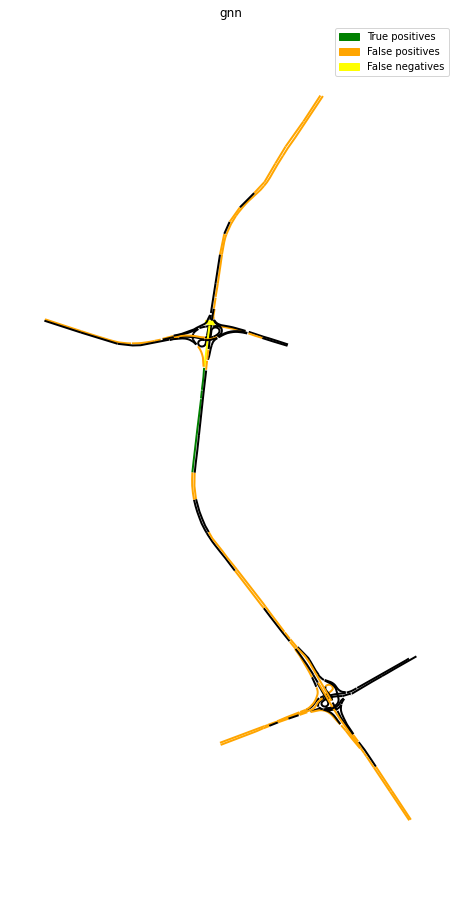

In [24]:
fig, ax = plt.subplots(figsize=(8,16))
fig1 = plot_classification_errors(y_hat=y_hat_dict[model_str],
y_true=y_true_dict[model_str],
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'gnn')

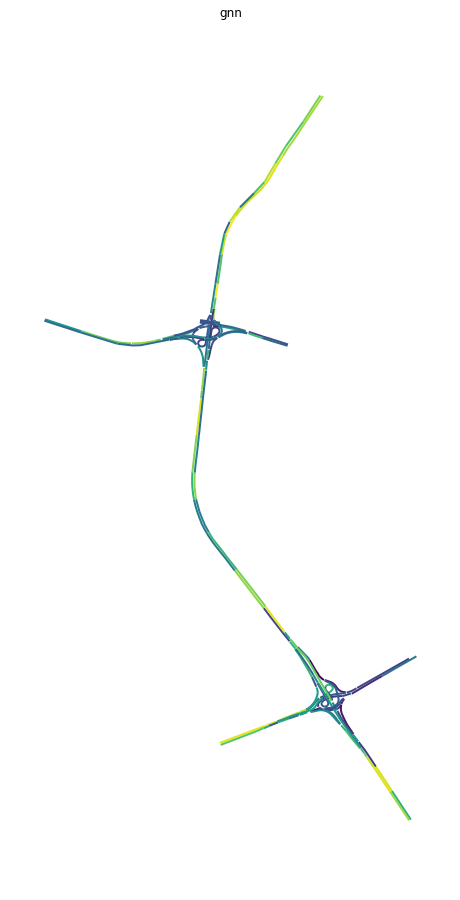

In [25]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=y_hat_dict[model_str],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'False neg')

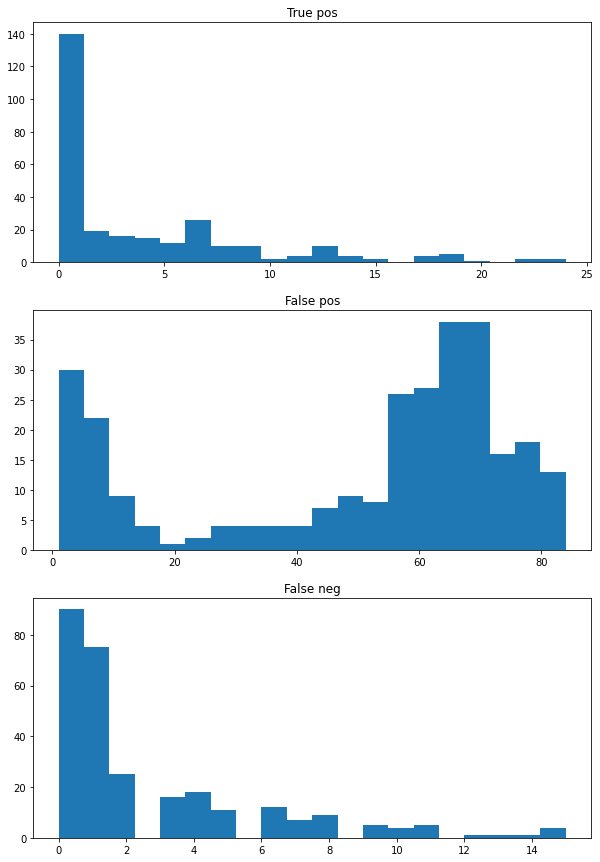

In [26]:
pred_classes = y_hat_dict[model_str][...,0] > 0
true_classes = y_true_dict[model_str][...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# Informed GNN Focus

In [27]:
metric_obj = MetricObj(bce_pos_weight=22.5178)
model_str = 'informed_gnn'
model_res_dict = {}
model_res_dict['full'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                            y_true=y_true_dict[model_str])

model_res_dict['upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=upstream_mask)

model_res_dict['not_upstream'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~upstream_mask)

model_res_dict['multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=multi_lane_block_mask)

model_res_dict['not_multi_lane'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~multi_lane_block_mask)

model_res_dict['highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=highway_ie_mask)

model_res_dict['not_highway'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~highway_ie_mask)
                                                
model_res_dict['spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=spreading_cong_mask)

model_res_dict['not_spreading'] = metric_obj.calc_metrics(y_hat=y_hat_dict[model_str],
                                                y_true=y_true_dict[model_str],
                                                mask=~spreading_cong_mask)

In [28]:
for mask_type in model_res_dict.keys():
    print_res_dict(model_res_dict[mask_type], mask_type)

************  Results for: full  ************
##class:##
bce : 0.29 	acc : 0.94 	prcsn : 0.42 	rcll : 0.96 	
##start:##
mse : 49.20 	mae : 1.22 	mape : 467650.94 	Mmape : 0.45 	
##end:##
mse : 268.53 	mae : 3.74 	mape : 1452140.38 	Mmape : 0.50 	
##speed:##
mse : 11.75 	mae : 0.96 	mape : 415049.91 	Mmape : 0.49 	
************  Results for: upstream  ************
##class:##
bce : 1.80 	acc : 0.61 	prcsn : 0.42 	rcll : 0.96 	
##start:##
mse : 318.33 	mae : 7.91 	mape : 3024499.25 	Mmape : 0.45 	
##end:##
mse : 1737.54 	mae : 24.20 	mape : 9394017.00 	Mmape : 0.50 	
##speed:##
mse : 76.03 	mae : 6.20 	mape : 2684279.25 	Mmape : 0.49 	
************  Results for: not_upstream  ************
##class:##
bce : 0.01 	acc : 1.00 	prcsn : 0.00 	rcll : 0.00 	
##start:##
mse : 0.00 	mae : 0.00 	mape : 266.89 	Mmape : nan 	
##end:##
mse : 0.00 	mae : 0.00 	mape : 389.79 	Mmape : nan 	
##speed:##
mse : 0.00 	mae : 0.00 	mape : 241.76 	Mmape : nan 	
************  Results for: multi_lane  ************


Text(0.5, 1.0, 'informed_gnn')

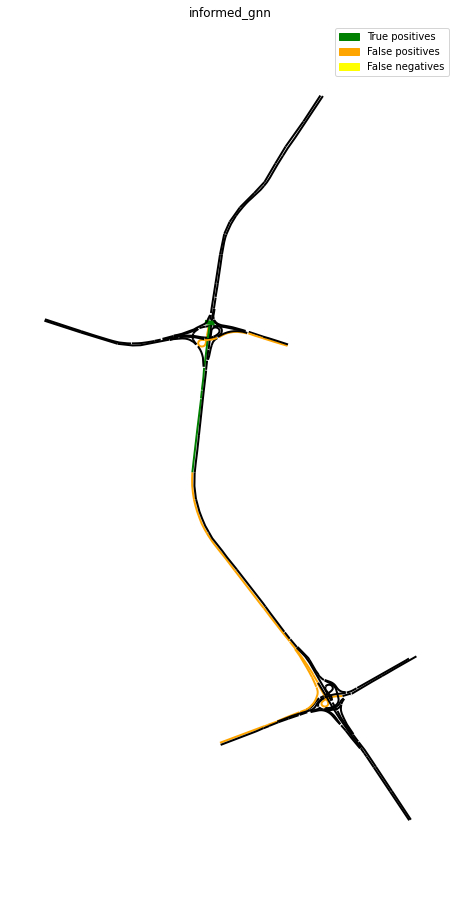

In [29]:
fig, ax = plt.subplots(figsize=(8,16))
fig1 = plot_classification_errors(y_hat=y_hat_dict[model_str],
y_true=y_true_dict[model_str],
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'informed_gnn')

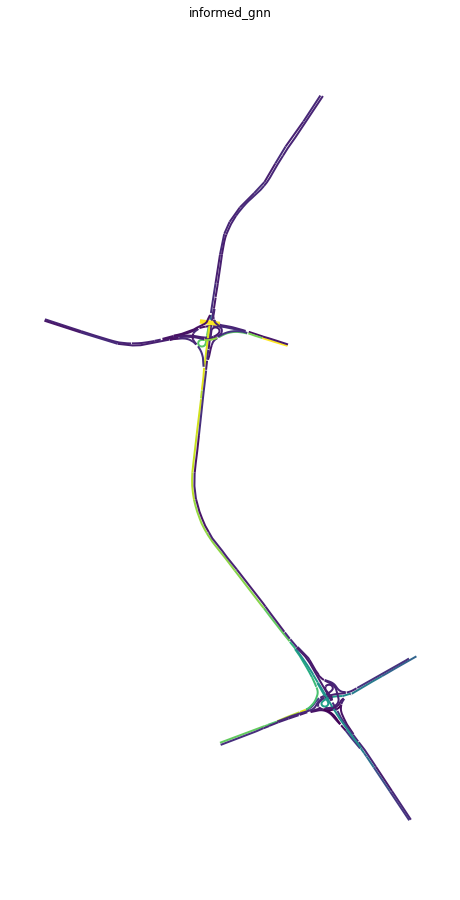

In [30]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=y_hat_dict[model_str],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(model_str)

Text(0.5, 1.0, 'False neg')

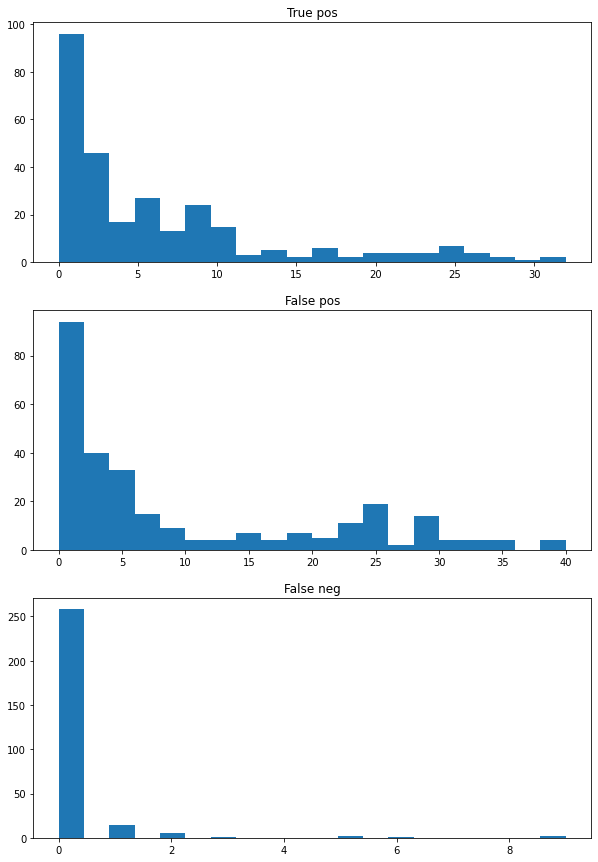

In [31]:
pred_classes = y_hat_dict[model_str][...,0] > 0
true_classes = y_true_dict[model_str][...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')

